In [1]:
from helical import scGPTConfig, scGPTFineTuningModel
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging, warnings
import umap
import pandas as pd
import seaborn as sns
import anndata as ad  # AnnData support


  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0+cu118 available.
INFO:datasets:JAX version 0.5.1 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


In [3]:
import anndata as ad  # Ensure AnnData support

# Load your dataset (update file path if needed)
adata = ad.read_h5ad("subset_30k_stratified_highvar.h5ad")  # Replace with your actual dataset path

# Ensure 'cell_type' column exists
if "cell_type" not in adata.obs:
    raise ValueError("The dataset must have a 'cell_type' column for classification.")

# Now, extract the label set correctly
label_set = adata.obs["cell_type"].astype("category").cat.categories

# Configure scGPT for fine-tuning on cell type classification
device = "cuda" if torch.cuda.is_available() else "cpu"

scgpt_config = scGPTConfig(batch_size=10, device=device)

# Initialize scGPT fine-tuning model
scgpt_fine_tune = scGPTFineTuningModel(
    scGPT_config=scgpt_config,
    fine_tuning_head="classification",
    output_size=len(label_set)  # Number of unique cell types
)


INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cls'.


In [56]:
print(model)

NameError: name 'model' is not defined

In [54]:
print(scGPTConfig)

<class 'helical.models.scgpt.scgpt_config.scGPTConfig'>


In [53]:
print(scGPTFineTuningModel)

<class 'helical.models.scgpt.fine_tuning_model.scGPTFineTuningModel'>


In [7]:
import numpy as np

# Check the min/max values
print(f"Min value: {adata.X.min()}, Max value: {adata.X.max()}")

# Check if data is in log scale
if np.max(adata.X) < 20:  # Raw UMI counts are usually much larger
    print("Data might be log-transformed. Attempting to recover raw counts.")


Min value: 0, Max value: 9
Data might be log-transformed. Attempting to recover raw counts.


In [8]:
import numpy as np

# Undo log transformation (if log1p was used)
adata.X = np.expm1(adata.X)  # Applies e^X - 1 to recover raw counts

# Round and convert to integers
adata.X = np.round(adata.X).astype(np.int32)

# Verify conversion
print(f"Data type after conversion: {adata.X.dtype}")
print(f"Min value: {adata.X.min()}, Max value: {adata.X.max()}")


Data type after conversion: int32
Min value: 0, Max value: 8102


In [3]:
from sklearn.model_selection import train_test_split
import anndata as ad

# Load the filtered dataset
adata = ad.read_h5ad("filtered_disease_only.h5ad")  # Make sure this file exists

# Ensure 'cell_type' column exists for stratification
if "cell_type" not in adata.obs.columns:
    raise ValueError("The dataset must have a 'cell_type' column in .obs for stratified sampling.")

# -------------------- STEP 1: Train-Test Split --------------------

# Split dataset into train (80%) and test (20%) while maintaining cell type distribution
train_indices, test_indices = train_test_split(
    adata.obs_names,
    test_size=0.2,  # 20% for testing
    stratify=adata.obs["cell_type"],  # Ensures balanced cell type distribution
    random_state=42
)

# Create train and test datasets from AnnData
train_dataset = adata[train_indices, :].copy()
test_dataset = adata[test_indices, :].copy()

print(f" Train dataset: {train_dataset.shape[0]} cells, {train_dataset.shape[1]} genes")
print(f" Test dataset: {test_dataset.shape[0]} cells, {test_dataset.shape[1]} genes")

# -------------------- STEP 2: Save Train and Test Datasets --------------------

train_dataset.write_h5ad("train_disease_only.h5ad")
test_dataset.write_h5ad("test_disease_only.h5ad")

print(" Train and test datasets saved as 'train_disease_only.h5ad' and 'test_disease_only.h5ad'.")


 Train dataset: 187695 cells, 45453 genes
 Test dataset: 46924 cells, 45453 genes
 Train and test datasets saved as 'train_disease_only.h5ad' and 'test_disease_only.h5ad'.


In [4]:
print(f"train_dataset.X dtype: {train_dataset.X.dtype}")
print(f"test_dataset.X dtype: {test_dataset.X.dtype}")


train_dataset.X dtype: float64
test_dataset.X dtype: float64


In [5]:
train_dataset.X = np.round(train_dataset.X).astype(np.int32)
test_dataset.X = np.round(test_dataset.X).astype(np.int32)  # Just to be safe


In [6]:
print(f"After conversion: train_dataset.X dtype: {train_dataset.X.dtype}")
print(f"After conversion: test_dataset.X dtype: {test_dataset.X.dtype}")


After conversion: train_dataset.X dtype: int32
After conversion: test_dataset.X dtype: int32


In [13]:
dataset = scgpt_fine_tune.process_data(train_dataset, gene_names="feature_name")  
validation_dataset = scgpt_fine_tune.process_data(test_dataset, gene_names="feature_name")


INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 1376 genes to a total of 3624 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 1376 genes to a total of 3624 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.


In [16]:
scgpt_fine_tune.train(
    train_input_data=dataset, 
    train_labels=cell_types_train, 
    validation_input_data=validation_dataset, 
    validation_labels=cell_types_test, 
    epochs=10,  # Increase epochs for better training
    optimizer_params={"lr": 2e-5, "weight_decay": 1e-4},  # Added weight decay for stability
    lr_scheduler_params={"name": "linear", "num_warmup_steps": 100, "num_training_steps": len(dataset) * 10}  # Warmup + proper scheduling
)

INFO:helical.models.scgpt.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning: epoch 10/10: 100%|█| 2400/2400 [01:47<00:00, 22.33it/s, loss=0.129]
Fine-Tuning Validation: 100%|█| 600/600 [00:05<00:00, 110.49it/s, val_loss=0.137
INFO:helical.models.scgpt.fine_tuning_model:Fine-Tuning Complete. Epochs: 10


In [51]:
import time

# Start time tracking
start_time = time.perf_counter()

# Train Model (with Multi-Task Learning Support)
scgpt_fine_tune.train(
    train_input_data=dataset, 
    train_labels=cell_types_train, 
    validation_input_data=validation_dataset, 
    validation_labels=cell_types_test, 
    epochs=1,  # Increase epochs for better training
    optimizer_params={"lr": 2e-5, "weight_decay": 1e-4},  # Added weight decay for stability
    lr_scheduler_params={"name": "linear", "num_warmup_steps": 100, "num_training_steps": len(dataset) * 10}  # Warmup + proper scheduling
)

# End time tracking
end_time = time.perf_counter()
print(f"Time per epoch: {end_time - start_time:.2f} seconds")


INFO:helical.models.scgpt.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|█| 600/600 [00:12<00:00, 46.57it/s, val_loss=0.124]
INFO:helical.models.scgpt.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


Time per epoch: 121.45 seconds


In [15]:
from sklearn.preprocessing import LabelEncoder
import torch

# Ensure 'cell_type' is categorical
train_labels = train_dataset.obs["cell_type"].astype("category")
test_labels = test_dataset.obs["cell_type"].astype("category")

# Encode cell types as numerical labels
label_encoder = LabelEncoder()
cell_types_train = label_encoder.fit_transform(train_labels)
cell_types_test = label_encoder.transform(test_labels)

# Convert to PyTorch tensor (scGPT expects tensors)
cell_types_train = torch.tensor(cell_types_train, dtype=torch.long)
cell_types_test = torch.tensor(cell_types_test, dtype=torch.long)

print(f"Cell type labels: {len(label_encoder.classes_)} unique classes")


Cell type labels: 11 unique classes


In [49]:
# Print label mapping
id2type = dict(enumerate(label_encoder.classes_))
for label, cell_type in id2type.items():
    print(f"Label {label}: {cell_type}")


Label 0: B cell
Label 1: T cell
Label 2: endothelial cell
Label 3: epithelial cell
Label 4: fibroblast
Label 5: malignant cell
Label 6: mast cell
Label 7: megakaryocyte
Label 8: mononuclear phagocyte
Label 9: neutrophil
Label 10: plasmacytoid dendritic cell


In [18]:
outputs = scgpt_fine_tune.get_outputs(validation_dataset)


Fine-Tuning Validation: 100%|████████████████| 600/600 [00:03<00:00, 153.50it/s]


In [19]:
embeddings = scgpt_fine_tune.get_embeddings(validation_dataset)

INFO:helical.models.scgpt.model:Started getting embeddings:
Embedding cells: 100%|███████████████████████| 600/600 [00:02<00:00, 207.77it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


Text(0.5, 1.0, 'UMAP of Reference Data with labels')

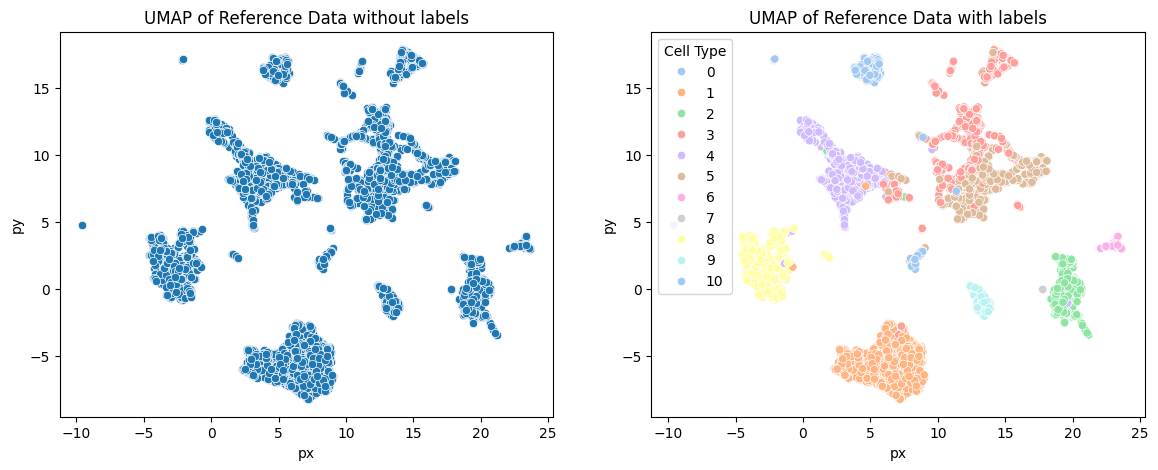

In [20]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None, n_neighbors=4)
mapper = reducer.fit(embeddings)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = cell_types_test
plot_df['Cell Type'] = labels


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

In [21]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       315
           1       0.99      0.99      0.99      1524
           2       0.99      0.99      0.99       489
           3       0.89      0.87      0.88       946
           4       0.97      0.98      0.98       817
           5       0.87      0.88      0.87       807
           6       1.00      0.97      0.99        70
           7       1.00      1.00      1.00         3
           8       0.99      1.00      0.99       809
           9       1.00      1.00      1.00       200
          10       1.00      1.00      1.00        20

    accuracy                           0.96      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.95      0.96      0.96      6000



In [46]:
from sklearn.metrics import classification_report

# Convert numerical predictions to cell type names
predicted_labels = outputs.argmax(axis=1)  # Get predicted class indices
true_labels = cell_types_test  # True labels (numeric)

# Get corresponding cell type names
cell_type_names = list(id2type.values())  # Extract cell type names from id2type

# Generate classification report with cell type names
print(classification_report(true_labels, predicted_labels, target_names=cell_type_names))


NameError: name 'id2type' is not defined

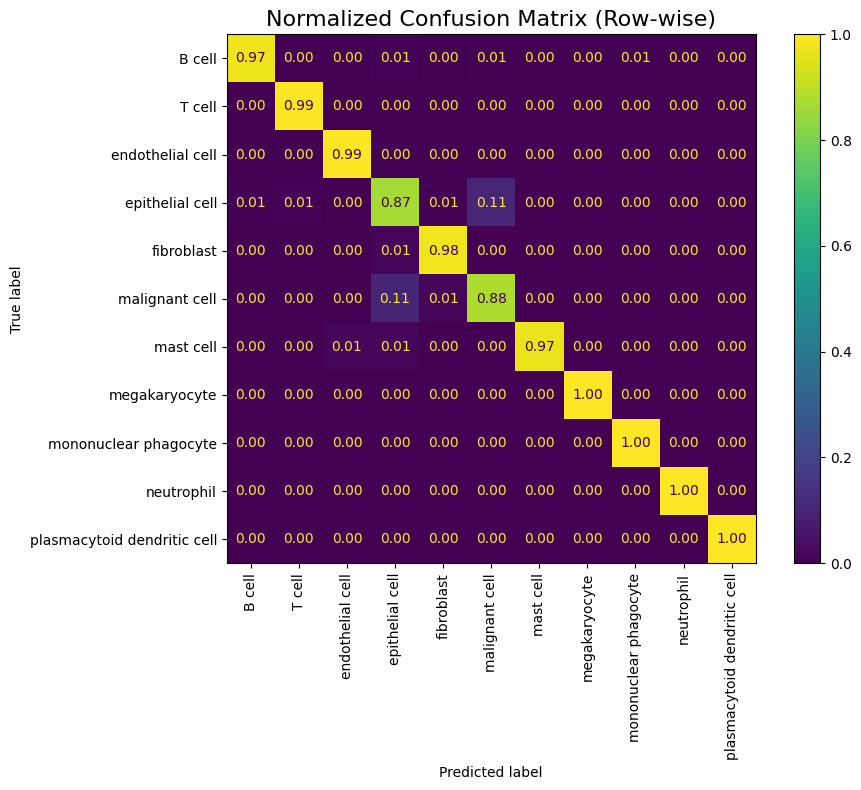

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Choose your color map
cmap_choice = "viridis"  # Change this to any cmap value from the table above

# Ensure label encoder exists (from training step)
id_class_dict = {idx: label for idx, label in enumerate(label_encoder.classes_)}

# Convert predicted labels and true labels to numerical format
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use the mapping to get class names
class_names = [id_class_dict[label] for label in unique_labels]

# Compute the confusion matrix
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap=cmap_choice)

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)', fontsize=16)
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions and true labels to NumPy arrays (if not already)
y_true = cell_types_test.numpy() if isinstance(cell_types_test, torch.Tensor) else cell_types_test
y_pred = outputs.argmax(axis=1).numpy() if isinstance(outputs, torch.Tensor) else outputs.argmax(axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted accounts for class imbalance
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Display results
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

metrics


{'Accuracy': 0.9551666666666667,
 'Precision': 0.9549444374103111,
 'Recall': 0.9551666666666667,
 'F1 Score': 0.9550283590051217}

In [32]:
import pandas as pd

# Ensure y_true and y_pred are correctly formatted
y_true = cell_types_test.numpy() if isinstance(cell_types_test, torch.Tensor) else cell_types_test
y_pred = outputs.argmax(axis=1).numpy() if isinstance(outputs, torch.Tensor) else outputs.argmax(axis=1)
sample_indices = np.random.choice(len(y_pred), 20, replace=False)
# Create a mapping from label indices to actual cell type names
id_class_dict = {idx: label for idx, label in enumerate(label_encoder.classes_)}

# Convert numerical labels back to cell type names
true_cell_types = [id_class_dict[label] for label in y_true]
predicted_cell_types = [id_class_dict[label] for label in y_pred]

# Create a DataFrame for comparison
df_predictions = pd.DataFrame({
    "True Cell Type": true_cell_types,
    "Predicted Cell Type": predicted_cell_types
})

# Display the results
from IPython.display import display
display(df_predictions)


,True Cell Type,Predicted Cell Type
0,B cell,B cell
1,malignant cell,malignant cell
2,mononuclear phagocyte,mononuclear phagocyte
3,epithelial cell,epithelial cell
4,epithelial cell,epithelial cell
...,...,...
5995,malignant cell,malignant cell
5996,malignant cell,epithelial cell
5997,T cell,T cell
5998,T cell,T cell


In [33]:
import pandas as pd

# Ensure y_true and y_pred are correctly formatted
y_true = cell_types_test.numpy() if isinstance(cell_types_test, torch.Tensor) else cell_types_test
y_pred = outputs.argmax(axis=1).numpy() if isinstance(outputs, torch.Tensor) else outputs.argmax(axis=1)

# Create a mapping from label indices to actual cell type names
id_class_dict = {idx: label for idx, label in enumerate(label_encoder.classes_)}

# Convert numerical labels back to cell type names
true_cell_types = [id_class_dict[label] for label in y_true]
predicted_cell_types = [id_class_dict[label] for label in y_pred]

# Create DataFrame
results_df = pd.DataFrame({
    "True Cell Type": true_cell_types,
    "Predicted Cell Type": predicted_cell_types
})

# Print first 10 rows
print(results_df.head(10))


          True Cell Type    Predicted Cell Type
0                 B cell                 B cell
1         malignant cell         malignant cell
2  mononuclear phagocyte  mononuclear phagocyte
3        epithelial cell        epithelial cell
4        epithelial cell        epithelial cell
5         malignant cell        epithelial cell
6       endothelial cell       endothelial cell
7                 T cell                 T cell
8             fibroblast             fibroblast
9                 T cell                 T cell


In [34]:
# Identify the top expressed genes in the dataset
import numpy as np
import pandas as pd

# Ensure adata.X is in dense format (if sparse)
if hasattr(adata.X, "toarray"):
    expression_matrix = adata.X.toarray()
else:
    expression_matrix = adata.X

# Compute mean expression per gene
gene_expression_means = np.mean(expression_matrix, axis=0)

# Create a DataFrame with gene names and their mean expression values
gene_expression_df = pd.DataFrame({
    "Gene": adata.var["feature_name"],
    "Mean Expression": gene_expression_means
})

# Sort genes by mean expression in descending order
top_expressed_genes = gene_expression_df.sort_values(by="Mean Expression", ascending=False).head(10)

# Print the top expressed genes
print(top_expressed_genes)


                    Gene  Mean Expression
index                                    
ENSG00000251562   MALAT1       365.675400
ENSG00000166710      B2M       131.923067
ENSG00000087086      FTL        91.560600
ENSG00000156508   EEF1A1        78.385233
ENSG00000112306    RPS12        54.933967
ENSG00000168484    SFTPC        37.469433
ENSG00000019582     CD74        33.256267
ENSG00000111640    GAPDH        28.666067
ENSG00000197956   S100A6        26.524233
ENSG00000210082  MT-RNR2        25.553233


In [35]:
import pandas as pd
import numpy as np

# Ensure adata contains raw count data
if 'cell_type' not in adata.obs:
    raise ValueError("The dataset must have a 'cell_type' column for classification.")

# Aggregate gene expression by cell type (mean expression per gene)
cell_type_groups = adata.to_df().groupby(adata.obs['cell_type']).mean()

# Get the top 5 expressed genes for each cell type
top_genes_per_cell_type = cell_type_groups.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)

# Convert to DataFrame for better readability
top_genes_df = pd.DataFrame(top_genes_per_cell_type.tolist(), index=top_genes_per_cell_type.index, 
                            columns=[f"Top Gene {i+1}" for i in range(5)])

# Display the results
from IPython.display import display
display(df_predictions)


,True Cell Type,Predicted Cell Type
0,B cell,B cell
1,malignant cell,malignant cell
2,mononuclear phagocyte,mononuclear phagocyte
3,epithelial cell,epithelial cell
4,epithelial cell,epithelial cell
...,...,...
5995,malignant cell,malignant cell
5996,malignant cell,epithelial cell
5997,T cell,T cell
5998,T cell,T cell


In [45]:
import pandas as pd
import numpy as np

# Ensure dataset is loaded
if 'cell_type' not in adata.obs:
    raise ValueError("The dataset must have a 'cell_type' column for classification.")

# ----- True vs Predicted Cell Type -----
# Convert predictions and true labels to NumPy arrays
y_true = cell_types_test.numpy() if isinstance(cell_types_test, torch.Tensor) else cell_types_test
y_pred = outputs.argmax(axis=1).numpy() if isinstance(outputs, torch.Tensor) else outputs.argmax(axis=1)

# Create a mapping from label indices to actual cell type names
id_class_dict = {idx: label for idx, label in enumerate(label_encoder.classes_)}

# Convert numerical labels back to cell type names
true_cell_types = [id_class_dict[label] for label in y_true]
predicted_cell_types = [id_class_dict[label] for label in y_pred]

# ----- Top Expressed Genes for Each Cell Type -----
# Aggregate gene expression by cell type (mean expression per gene)
cell_type_groups = adata.to_df().groupby(adata.obs['cell_type']).mean()

# Ensure feature names are mapped to Ensembl IDs
gene_mapping = adata.var['feature_name'].to_dict()

# Convert Ensembl IDs to gene names
cell_type_groups.rename(columns=gene_mapping, inplace=True)

# Get the top 5 expressed genes for each cell type
top_genes_per_cell_type = cell_type_groups.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)

# Convert to DataFrame for better readability
top_genes_df = pd.DataFrame(top_genes_per_cell_type.tolist(), index=top_genes_per_cell_type.index, 
                            columns=[f"Top Gene {i+1}" for i in range(5)])

# ----- Combine Data -----
results_df = pd.DataFrame({
    "True Cell Type": true_cell_types,
    "Predicted Cell Type": predicted_cell_types
})

# Merge with top expressed genes
final_df = results_df.merge(top_genes_df, left_on="True Cell Type", right_index=True, how="left")

# Display the dataframe in Jupyter Notebook
from IPython.display import display
display(final_df.head(10))


,True Cell Type,Predicted Cell Type,Top Gene 1,Top Gene 2,Top Gene 3,Top Gene 4,Top Gene 5
0,B cell,B cell,MALAT1,IGKC,IGLC2,B2M,CD74
1,malignant cell,malignant cell,MALAT1,EEF1A1,GAPDH,FTL,RPS12
2,mononuclear phagocyte,mononuclear phagocyte,FTL,MALAT1,B2M,CD74,HLA-DRA
3,epithelial cell,epithelial cell,SFTPC,MALAT1,EEF1A1,RPS12,FTL
4,epithelial cell,epithelial cell,SFTPC,MALAT1,EEF1A1,RPS12,FTL
5,malignant cell,epithelial cell,MALAT1,EEF1A1,GAPDH,FTL,RPS12
6,endothelial cell,endothelial cell,MALAT1,B2M,MT2A,CD74,CLDN5
7,T cell,T cell,MALAT1,B2M,EEF1A1,RPS12,FTL
8,fibroblast,fibroblast,MALAT1,COL1A1,B2M,EEF1A1,FTL
9,T cell,T cell,MALAT1,B2M,EEF1A1,RPS12,FTL
